# Coffee, Tea & EMD

This post is geared towards understanding wholesale prices of Coffee and Tea using signal processing techniques like FFT and EMD.

The objective is to import data on whole sale prices, calculate the statistical summary, plot the time series and observe trends and seasonality in prices.

Wholesale price units: coffee/tea = Rs/quintal

In [3]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [134]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy import fftpack
from PyEMD import EMD

## Importing Dataset

In [41]:
#Loose Coffee Data
filename = ['datafile'+str(x)+'.csv' for x in np.arange(1,9)]
cols = ['state','district','market','commodity','variety','arrival_date','min_price','max_price','modal_price']
coffee_df = pd.DataFrame([], columns=cols)
for f in filename:
    data = pd.read_csv(f)
    coffee_df = pd.concat([coffee_df, data],axis=0)
#Loose Tea Data   
tea_df = pd.read_csv('tea_dataset.csv')

## Data Pre-Processing

### Cleaning Coffee Data

In [42]:
coffee_df['min_price'] = coffee_df['min_price'].apply(lambda x: int(x))
coffee_df['max_price'] = coffee_df['max_price'].apply(lambda x: int(x))
coffee_df['modal_price'] = coffee_df['modal_price'].apply(lambda x: int(x))
coffee_df = coffee_df.reset_index(drop=True)
coffee_df['arrival_date'] = pd.to_datetime(coffee_df['arrival_date'])
coffee_df = coffee_df.sort_values('arrival_date')
coffee_df = coffee_df.set_index('arrival_date')

In [43]:
coffee_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11515 entries, 2003-01-07 to 2019-12-02
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        11515 non-null  object
 1   district     11515 non-null  object
 2   market       11515 non-null  object
 3   commodity    11515 non-null  object
 4   variety      11515 non-null  object
 5   min_price    11515 non-null  int64 
 6   max_price    11515 non-null  int64 
 7   modal_price  11515 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 809.6+ KB


In [44]:
coffee_df.describe().round(2)

,min_price,max_price,modal_price
count,11515.00,11515.00,11515.00
mean,10473.48,11217.89,10972.26
std,4904.28,5194.83,5034.87
min,0.00,0.00,0.00
25%,7000.00,7600.00,7500.00
50%,10800.00,11300.00,11000.00
75%,12500.00,13200.00,13000.00
max,107000.00,110000.00,108500.00


How can minimum price be 0 ? Investigate

In [45]:
coffee_df = coffee_df.drop(index = coffee_df.loc[(coffee_df.min_price==0)|
                            (coffee_df.max_price==0)|
                            (coffee_df.modal_price==0)].index)

In [46]:
coffee_df.describe().round(2)

,min_price,max_price,modal_price
count,11488.00,11488.00,11488.00
mean,10474.89,11220.75,10974.51
std,4906.51,5196.34,5037.03
min,140.00,160.00,150.00
25%,7000.00,7600.00,7500.00
50%,10800.00,11300.00,11000.00
75%,12500.00,13200.00,13000.00
max,107000.00,110000.00,108500.00


## Cleaning Tea Data

In [47]:
def data_cleaner(df):
    df = df.dropna()
    df['date'] = pd.to_datetime(df['Date'])
    df = df.set_index('date').drop(['Date'],axis=1)
    return df

In [48]:
tea_df = data_cleaner(tea_df)

In [49]:
tea_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114495 entries, 1997-11-25 to 2015-04-28
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Centre_Name     114495 non-null  object 
 1   Commodity_Name  114495 non-null  object 
 2   Price           114495 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.5+ MB


## Concatenating all commodities

In [51]:
# We select the modal_price for coffee and aggregate over the whole country
data0 = coffee_df.loc['2010':'2014', 'modal_price'].resample('D').mean()
# We aggregate over the whole country for the rest of the commodities
data1 = tea_df.loc['2010':'2014', 'Price'].resample('D').mean()

In [52]:
comm_df = pd.concat([data0, data1],axis=1)
comm_df.columns = ['coffee','tea']
comm_df = comm_df.dropna()
comm_df = comm_df.fillna(method='ffill')

***
## Summary Statistics

In [53]:
comm_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1121 entries, 2010-01-01 to 2014-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   coffee  1121 non-null   float64
 1   tea     1121 non-null   float64
dtypes: float64(2)
memory usage: 26.3 KB


In [54]:
comm_df.describe().round(2)

,coffee,tea
count,1121.00,1121.00
mean,13077.75,191.62
std,4090.13,12.36
min,2200.00,161.41
25%,10925.00,179.80
50%,12600.00,192.26
75%,13700.00,202.75
max,27500.00,221.88


In [55]:
comm_df.std()*100/comm_df.mean()

coffee    31.275448
tea        6.451272
dtype: float64

***
# Time Series Analysis

## Time Series Plot

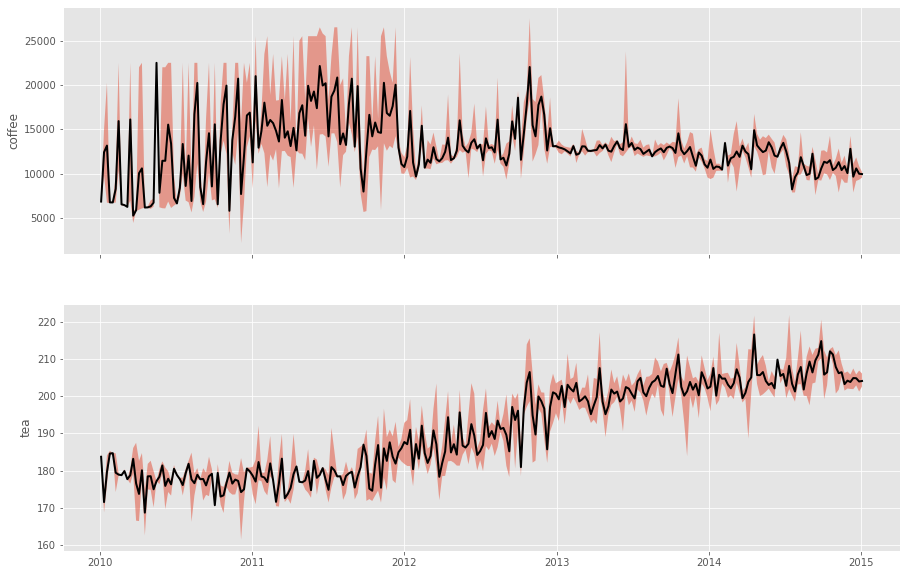

In [58]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=[15,10])

for i in range(0,2):
    c = comm_df.iloc[:,i]
    c_low = c.resample('W').min()
    c_high = c.resample('W').max()
    c_mean = c.resample('W').mean()
    
    ax[i].plot(c_low.index, c_low.values, linewidth=2, linestyle='')
    ax[i].plot(c_mean.index, c_mean.values, linewidth=2, color='k')
    ax[i].plot(c_high.index, c_high.values, linewidth=2, linestyle='')
    ax[i].fill_between(c_low.index, c_low.values, c_high.values, alpha=0.5)
    ax[i].set_ylabel(comm_df.columns[i])

Text(0, 0.5, 'Tea Price (Rs/quintal)')

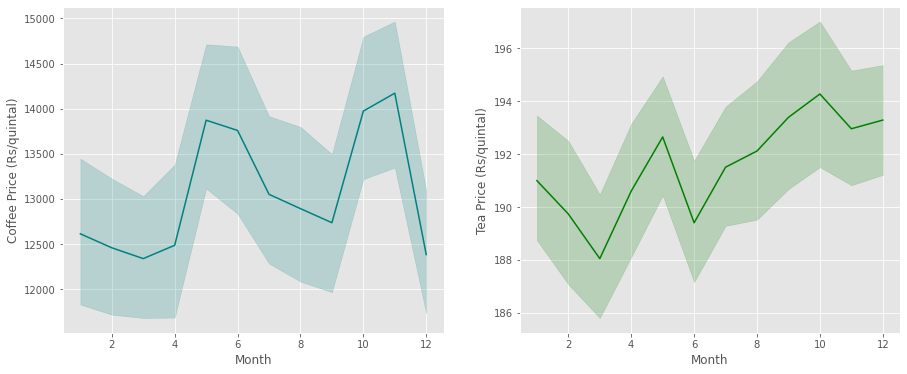

In [143]:
fig,ax = plt.subplots(1,2,figsize=[15,6])
sns.lineplot(comm_df.index.month, comm_df.coffee, color='teal', ax=ax[0])
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Coffee Price (Rs/quintal)')

sns.lineplot(comm_df.index.month, comm_df.tea, color='green', ax=ax[1])
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Tea Price (Rs/quintal)')

Coffee are harvested from November till February, so that explains the low prices in these months. (http://www.agritech.tnau.ac.in/horticulture/horti_plantation%20crops_coffee.html)

Tea is picked thrice in a year: First flush in end of Feb, early March
Second flush in April and May; third flush from July -August and autmn flush in October-Nov (https://rove.me/to/india/tea-harvest#:~:text=From%20March%20to%20September%20the,collected%20twice%20during%20a%20season.)

# Decomposing the Data

In [65]:
d0 = comm_df.coffee.resample('D').mean().fillna(method='ffill')
d1 = comm_df.tea.resample('D').mean().fillna(method='ffill')

## Seasonalility - Linear Model - MA

Text(0.5, 0, 'Days')

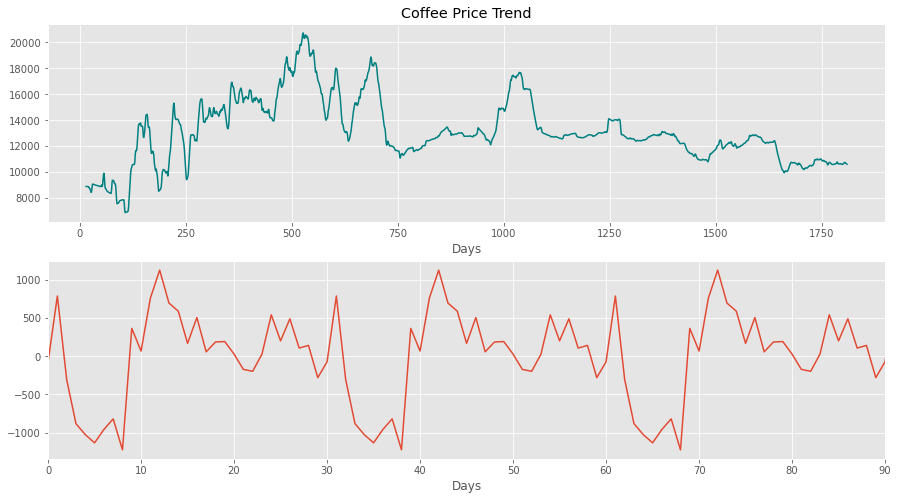

In [96]:
fig,ax = plt.subplots(2,1, figsize=[15,8])
decompose1 = seasonal_decompose(d0.values, model='additive', freq=30)
ax[0].set_title('Coffee Price Trend')
ax[0].plot(decompose1.trend, color='teal')
ax[0].set_xlabel('Days')
ax[1].plot(decompose1.seasonal)
ax[1].set_xlim(0,90)
ax[1].set_xlabel('Days')

Text(0.5, 0, 'Days')

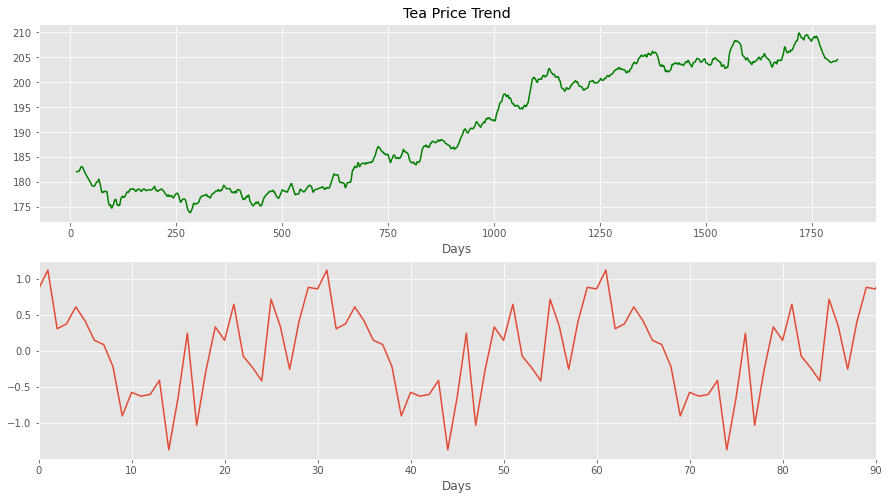

In [144]:
fig,ax = plt.subplots(2,1, figsize=[15,8])
decompose1 = seasonal_decompose(d1.values, model='additive', freq=30)
ax[0].set_title('Tea Price Trend')
ax[0].plot(decompose1.trend, color='green')
ax[0].set_xlabel('Days')
ax[1].plot(decompose1.seasonal)
ax[1].set_xlim(0,90)
ax[1].set_xlabel('Days')

## Seasonility - Linear Model - FFT

Text(0, 0.5, 'Power (Amplitude**2)')

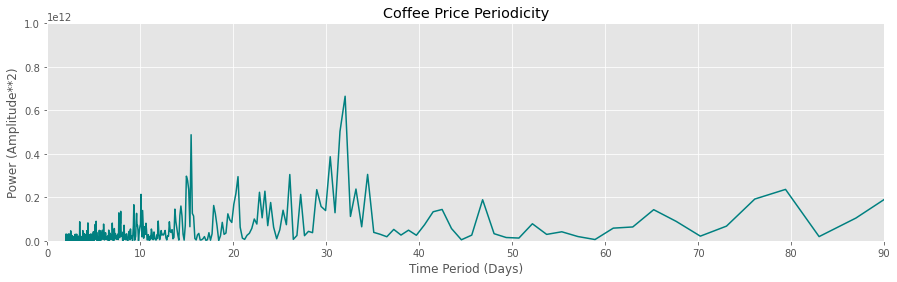

In [146]:
sig = d0.values
time_step = 1 #1 day
sig_fft = fftpack.fft(sig)
sample_freq = fftpack.fftfreq(sig.size, d=time_step)
power = np.abs(sig_fft)**2
    
pos_mask = np.where(sample_freq>0) #Considering only the positive componenets
freqs = sample_freq[pos_mask]
power = power[pos_mask]

fig = plt.subplots(figsize=[15,4])
plt.title('Coffee Price Periodicity')
plt.plot(1/freqs, power, color='teal')
plt.xlim(0,90)
plt.ylim(0,1E12)
plt.xlabel('Time Period (Days)')
plt.ylabel('Power (Amplitude**2)')

Text(0, 0.5, 'Power (Amplitude**2)')

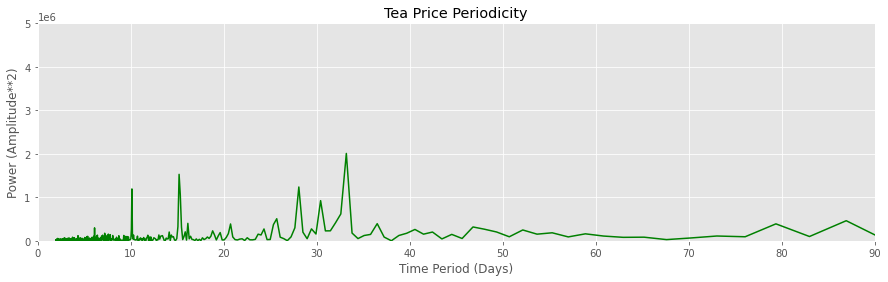

In [147]:
sig = d1.values
time_step = 1 #1 day
sig_fft = fftpack.fft(sig)
sample_freq = fftpack.fftfreq(sig.size, d=time_step)
power = np.abs(sig_fft)**2
    
pos_mask = np.where(sample_freq>0) #Considering only the positive componenets
freqs = sample_freq[pos_mask]
power = power[pos_mask]

fig = plt.subplots(figsize=[15,4])
plt.title('Tea Price Periodicity')
plt.plot(1/freqs, power, color='green')
plt.xlim(0,90)
plt.ylim(0,0.5E7)
plt.xlabel('Time Period (Days)')
plt.ylabel('Power (Amplitude**2)')

## Seasonility - Non-Linear Model - EMD

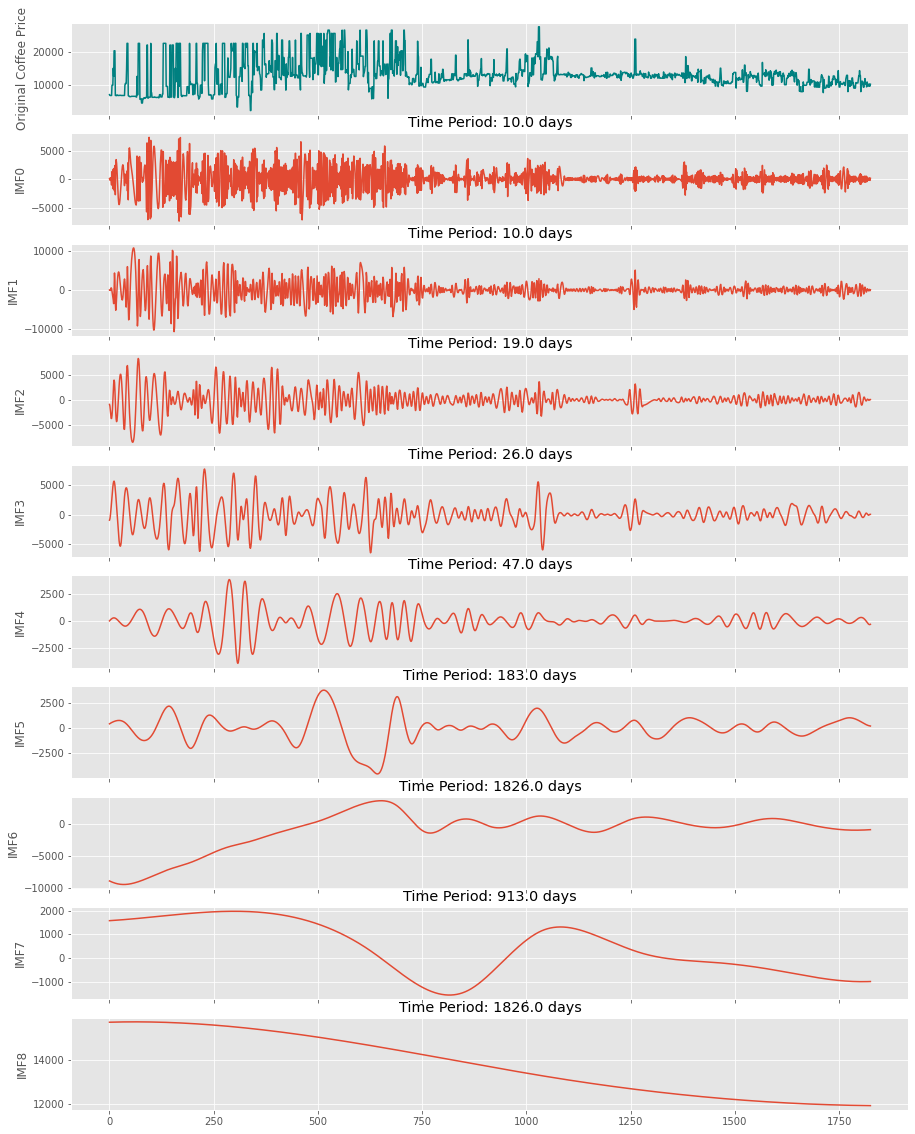

In [148]:
emd = EMD()
t = np.arange(0,d0.shape[0])
imfs = emd(d0.values, t)

fig,ax = plt.subplots(imfs.shape[0]+1, 1, sharex=True, figsize=[15,20])
ax[0].plot(t,d0.values, color='teal')
ax[0].set_ylabel('Original Coffee Price')

for i in range(0,imfs.shape[0]):
    ax[i+1].plot(t, imfs[i])
    ax[i+1].set_ylabel('IMF'+str(i))
    
    sig = imfs[i]
    time_step = 1 #1 Day
    sig_fft = fftpack.fft(sig)
    sample_freq = fftpack.fftfreq(sig.size, d=time_step)
    power = np.abs(sig_fft)
    pos = np.where(sample_freq>0)
    power = power[pos]
    sample_period = 1/sample_freq[pos]
    s = sample_period[np.where(power==power.max())][0]
    ax[i+1].set_title('Time Period: {} days'.format(np.round(s)))
    

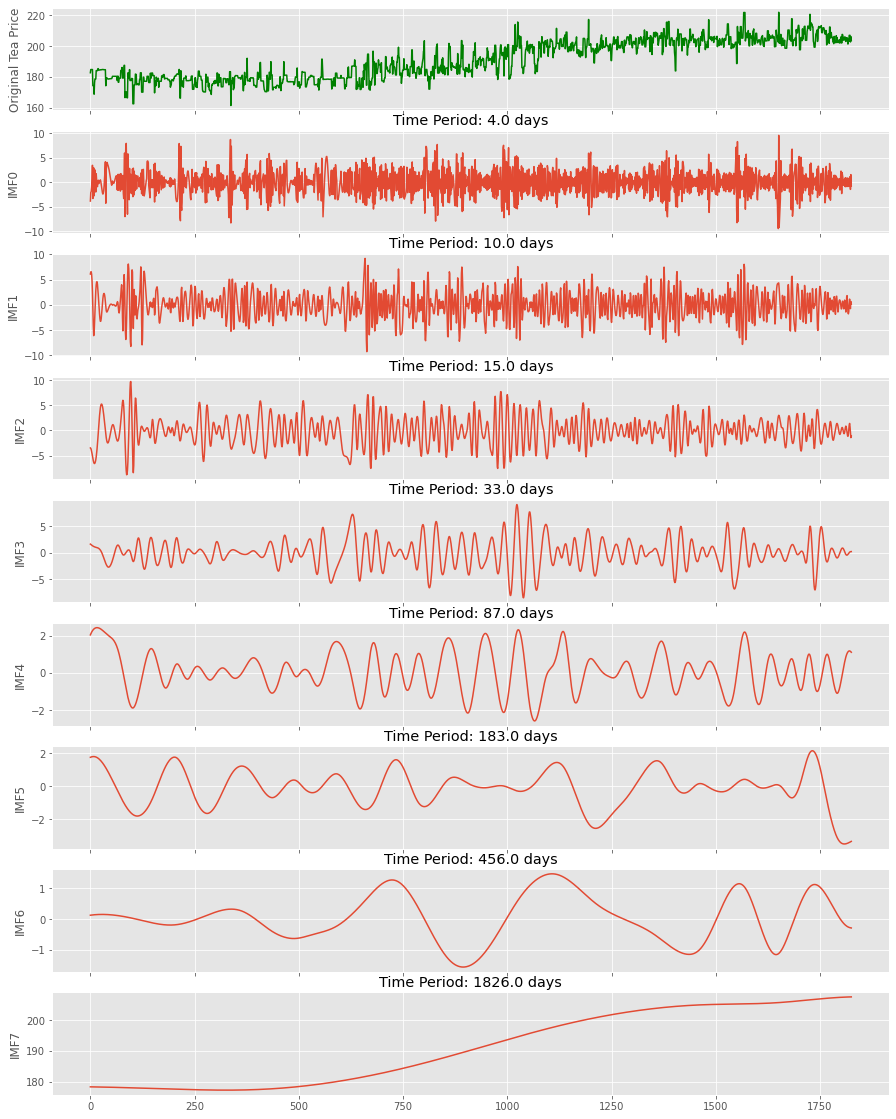

In [149]:
emd = EMD()
t = np.arange(0,d1.shape[0])
imfs = emd(d1.values, t)

fig,ax = plt.subplots(imfs.shape[0]+1, 1, sharex=True, figsize=[15,20])
ax[0].plot(t,d1.values, color='green')
ax[0].set_ylabel('Original Tea Price')

for i in range(0,imfs.shape[0]):
    ax[i+1].plot(t, imfs[i])
    ax[i+1].set_ylabel('IMF'+str(i))
    
    sig = imfs[i]
    time_step = 1 #1 Day
    sig_fft = fftpack.fft(sig)
    sample_freq = fftpack.fftfreq(sig.size, d=time_step)
    power = np.abs(sig_fft)
    pos = np.where(sample_freq>0)
    power = power[pos]
    sample_period = 1/sample_freq[pos]
    s = sample_period[np.where(power==power.max())][0]
    ax[i+1].set_title('Time Period: {} days'.format(np.round(s)))
    